## Setting the stage

We import all necessary packages.

In [71]:
import numpy as np
import pandas as pd
import scipy.optimize as optim
import seaborn as sns

import pycountry_convert as pc

## Reading the data

We examine the first few rows of our data.

In [72]:
df = pd.read_csv('./ai-ml-salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,MI,FT,Machine Learning Engineer,130000,USD,130000,US,0,US,M
1,2022,MI,FT,Machine Learning Engineer,90000,USD,90000,US,0,US,M
2,2022,MI,FT,Data Scientist,120000,USD,120000,US,100,US,M
3,2022,MI,FT,Data Scientist,100000,USD,100000,US,100,US,M
4,2022,MI,FT,Data Scientist,85000,USD,85000,US,100,US,M


We check for any missing values in the data. This data contains no missing values.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           1332 non-null   int64 
 1   experience_level    1332 non-null   object
 2   employment_type     1332 non-null   object
 3   job_title           1332 non-null   object
 4   salary              1332 non-null   int64 
 5   salary_currency     1332 non-null   object
 6   salary_in_usd       1332 non-null   int64 
 7   employee_residence  1332 non-null   object
 8   remote_ratio        1332 non-null   int64 
 9   company_location    1332 non-null   object
 10  company_size        1332 non-null   object
dtypes: int64(4), object(7)
memory usage: 114.6+ KB


We check the distribution of the variable we're most interested in and would likely use as target variable. The distribution could use a power transformation for a more normalized distribution but we will come back to this again if needed.

<AxesSubplot:ylabel='Frequency'>

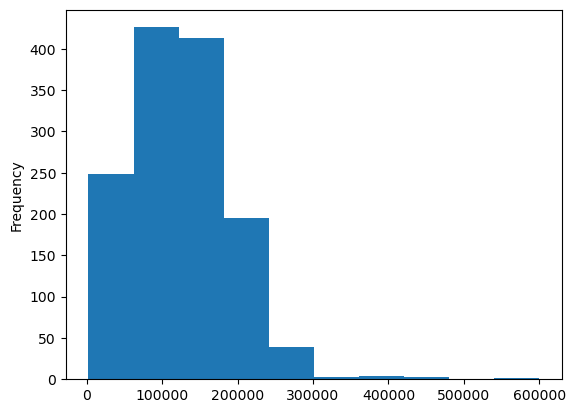

In [74]:
df['salary_in_usd'].plot(kind='hist')

The majority of our data represents salaries from 2022. However, the quantiles of salaries from other work years indicate that it is not skewed by work year. We will therefore not get rid of this data.

In [75]:
df.groupby('work_year').describe()

salary                                                          \
            count           mean           std     min      25%       50%   
work_year                                                                   
2020         75.0  394024.120000  1.387947e+06  8000.0  53499.5   98000.0   
2021        228.0  528850.846491  2.339520e+06  4000.0  59000.0  100000.0   
2022       1029.0  161810.586978  3.594636e+05  2324.0  90000.0  134000.0   

                                salary_in_usd                 ...            \
                75%         max         count           mean  ...       75%   
work_year                                                     ...             
2020       172500.0  11000000.0          75.0   92644.413333  ...  114523.5   
2021       174000.0  30400000.0         228.0   97400.850877  ...  131269.5   
2022       175100.0   7500000.0        1029.0  131369.601555  ...  170000.0   

                    remote_ratio                                          \
                max        count       mean        std  min   25%    50%   
work_year                                                                  
2020       450000.0         75.0  66.000000  39.558373  0.0  50.0  100.0   
2021       600000.0        228.0  69.078947  36.625656  0.0  50.0  100.0   
2022       405000.0       1029.0  62.536443  47.282987  0.0   0.0  100.0   

                         
             75%    max  
work_year                
2020       100.0  100.0  
2021       100.0  100.0  
2022       100.0  100.0  

[3 rows x 24 columns]

Since we already have salary in USD, we do not need salary figures in original currency or the name of those currencies.

In [76]:
df.drop(['salary','salary_currency'],1,inplace=True)
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,MI,FT,Machine Learning Engineer,130000,US,0,US,M
1,2022,MI,FT,Machine Learning Engineer,90000,US,0,US,M
2,2022,MI,FT,Data Scientist,120000,US,100,US,M
3,2022,MI,FT,Data Scientist,100000,US,100,US,M
4,2022,MI,FT,Data Scientist,85000,US,100,US,M


Let us explore if our textual data about job title could somehow be related to the salary of the employee. We could potential encode this data by vectorizing and see if that could improve our prediction model. Since we do not have any other continuous variables in the data, regression analysis for this data will not be the optimal approach. 

In [77]:
title_info = df.groupby('job_title')[['salary_in_usd']].agg(['count','mean'])
print(title_info.to_string())

                                         salary_in_usd               
                                                 count           mean
job_title                                                            
3D Computer Vision Researcher                        3    4244.333333
AI Scientist                                        12   78967.750000
Analytics Engineer                                  43  136638.465116
Applied Data Scientist                               6  154712.500000
Applied Machine Learning Scientist                   9  114555.555556
Applied Scientist                                    4  172150.000000
BI Analyst                                           4  100500.000000
BI Data Analyst                                     12   55803.083333
Big Data Architect                                   1   99703.000000
Big Data Engineer                                    9   64254.888889
Business Data Analyst                                8   85213.000000
Cloud Data Architect

We explore the distribution of countries among employees and whether that reflects in the mean salary. If there is a general pattern, we will reduce this categorical variable to less categories such as by grouping into continents. 

In [78]:
country_info = df.groupby('employee_residence')[['salary_in_usd']].agg(['count','mean'])
print(country_info.to_string())

                   salary_in_usd               
                           count           mean
employee_residence                             
AE                             3  100000.000000
AR                             3   52666.666667
AT                             4   69371.500000
AU                             9   83675.333333
AX                             1    2324.000000
BE                             4   76936.000000
BG                             1   80000.000000
BO                             3   52500.000000
BR                            17   50256.352941
CA                            38  106414.894737
CH                             1  120221.000000
CL                             2   72519.000000
CN                             2   84367.500000
CO                             1   21844.000000
CR                             1   20000.000000
CZ                             2   37565.500000
DE                            31   83539.806452
DK                             3   31192

We explore how type of employment could reflect in salary, but we have very few samples from other employment types than full time. Even with a high accuracy, our model could perform bad for those employment types.

In [79]:
df.groupby('employment_type').describe()

work_year                                                 \
                    count         mean       std     min     25%     50%   
employment_type                                                            
CT                    8.0  2021.375000  0.744024  2020.0  2021.0  2021.5   
FL                    5.0  2021.200000  0.836660  2020.0  2021.0  2021.0   
FT                 1306.0  2021.725881  0.554926  2020.0  2022.0  2022.0   
PT                   13.0  2021.153846  0.688737  2020.0  2021.0  2021.0   

                                salary_in_usd                 ...            \
                    75%     max         count           mean  ...       75%   
employment_type                                               ...             
CT               2022.0  2022.0           8.0  134879.125000  ...  146250.0   
FL               2022.0  2022.0           5.0   44557.400000  ...   60000.0   
FT               2022.0  2022.0        1306.0  124387.715926  ...  165000.0   
PT               2022.0  2022.0          13.0   44836.000000  ...   69741.0   

                          remote_ratio                                     \
                      max        count       mean        std   min    25%   
employment_type                                                             
CT               416000.0          8.0  93.750000  17.677670  50.0  100.0   
FL               100000.0          5.0  70.000000  44.721360   0.0   50.0   
FT               600000.0       1306.0  63.591118  45.496475   0.0    0.0   
PT               125404.0         13.0  69.230769  25.318484  50.0   50.0   

                                      
                   50%    75%    max  
employment_type                       
CT               100.0  100.0  100.0  
FL               100.0  100.0  100.0  
FT               100.0  100.0  100.0  
PT                50.0  100.0  100.0  

[4 rows x 24 columns]

We use the pycountry package to convert Alpha 2 country codes to continent codes to reduce our number of categories. One immediate observation is that employees in the North American continent and Oceanic continent have higher mean salaries.

In [80]:
country_list = df.groupby('employee_residence')['employee_residence'].unique().to_list()
new_list=[item.astype('str')[0] for item in country_list]

In [81]:
lst = df['employee_residence'].apply(lambda x: pc.country_alpha2_to_continent_code(x))
df['employee_continent'] = lst
df.groupby('employee_continent').describe()

work_year                                                  \
                       count         mean       std     min      25%     50%   
employee_continent                                                             
AF                       7.0  2021.428571  0.786796  2020.0  2021.00  2022.0   
AS                      82.0  2021.170732  0.681409  2020.0  2021.00  2021.0   
EU                     248.0  2021.439516  0.711652  2020.0  2021.00  2022.0   
NA                     959.0  2021.837331  0.441368  2020.0  2022.00  2022.0   
OC                      10.0  2021.600000  0.699206  2020.0  2021.25  2022.0   
SA                      26.0  2021.730769  0.452344  2021.0  2021.25  2022.0   

                                   salary_in_usd                 ...  \
                       75%     max         count           mean  ...   
employee_continent                                               ...   
AF                  2022.0  2022.0           7.0   60372.142857  ...   
AS                  2022.0  2022.0          82.0   46958.585366  ...   
EU                  2022.0  2022.0         248.0   69091.181452  ...   
NA                  2022.0  2022.0         959.0  146728.263816  ...   
OC                  2022.0  2022.0          10.0   87807.800000  ...   
SA                  2022.0  2022.0          26.0   51413.076923  ...   

                                        remote_ratio                        \
                          75%       max        count       mean        std   
employee_continent                                                           
AF                   75000.00  200000.0          7.0  92.857143  18.898224   
AS                   62783.25  260000.0         82.0  65.243902  39.821379   
EU                   86698.00  230000.0        248.0  57.661290  41.502331   
NA                  180000.00  600000.0        959.0  64.442127  46.902784   
OC                  114872.75  150000.0         10.0  65.000000  33.747428   
SA                   77250.00  160000.0         26.0  88.461538  29.351975   

                                                      
                     min    25%    50%    75%    max  
employee_continent                                    
AF                  50.0  100.0  100.0  100.0  100.0  
AS                   0.0   50.0  100.0  100.0  100.0  
EU                   0.0    0.0   50.0  100.0  100.0  
NA                   0.0    0.0  100.0  100.0  100.0  
OC                   0.0   50.0   50.0  100.0  100.0  
SA                   0.0  100.0  100.0  100.0  100.0  

[6 rows x 24 columns]

We repeat the same pre-processing for company country information as well. Using both these sets could result in multicollinearity in our model, but we will take that call later. 

In [82]:
lst = df['company_location'].apply(lambda x: pc.country_alpha2_to_continent_code(x))
df['company_continent'] = lst
df.groupby('company_continent').describe()

work_year                                                  \
                      count         mean       std     min      25%     50%   
company_continent                                                             
AF                      6.0  2021.333333  0.816497  2020.0  2021.00  2021.5   
AS                     67.0  2021.164179  0.687486  2020.0  2021.00  2021.0   
EU                    242.0  2021.466942  0.700431  2020.0  2021.00  2022.0   
NA                    987.0  2021.818642  0.464279  2020.0  2022.00  2022.0   
OC                     12.0  2021.583333  0.668558  2020.0  2021.00  2022.0   
SA                     18.0  2021.722222  0.460889  2021.0  2021.25  2022.0   

                                  salary_in_usd                 ...  \
                      75%     max         count           mean  ...   
company_continent                                               ...   
AF                 2022.0  2022.0           6.0   65345.333333  ...   
AS                 2022.0  2022.0          67.0   41274.477612  ...   
EU                 2022.0  2022.0         242.0   68944.190083  ...   
NA                 2022.0  2022.0         987.0  144726.664640  ...   
OC                 2022.0  2022.0          12.0   78844.250000  ...   
SA                 2022.0  2022.0          18.0   38985.555556  ...   

                                       remote_ratio                        \
                         75%       max        count       mean        std   
company_continent                                                           
AF                  87500.00  200000.0          6.0  91.666667  20.412415   
AS                  58794.00  260000.0         67.0  59.701493  41.045804   
EU                  86273.50  230000.0        242.0  57.438017  41.327132   
NA                 180000.00  600000.0        987.0  65.096251  46.642504   
OC                  94618.25  150000.0         12.0  70.833333  33.427896   
SA                  53000.00   84000.0         18.0  83.333333  34.299717   

                                                     
                    min    25%    50%    75%    max  
company_continent                                    
AF                 50.0  100.0  100.0  100.0  100.0  
AS                  0.0   25.0   50.0  100.0  100.0  
EU                  0.0    0.0   50.0  100.0  100.0  
NA                  0.0    0.0  100.0  100.0  100.0  
OC                  0.0   50.0   75.0  100.0  100.0  
SA                  0.0  100.0  100.0  100.0  100.0  

[6 rows x 24 columns]

We engineer this new feature of being co-located and examine if that could be helpful. The sample size for people not colocated is very small but there is a dramatic difference in salaries.

In [83]:
df['is_colocated']=np.where(df['employee_residence']==df['company_location'],1,0)
df.groupby('is_colocated').describe()

work_year                                                         \
                 count         mean       std     min     25%     50%     75%   
is_colocated                                                                    
0                 67.0  2021.298507  0.674535  2020.0  2021.0  2021.0  2022.0   
1               1265.0  2021.738340  0.547138  2020.0  2022.0  2022.0  2022.0   

                     salary_in_usd                 ...                      \
                 max         count           mean  ...       75%       max   
is_colocated                                       ...                       
0             2022.0          67.0   73478.671642  ...  100000.0  225000.0   
1             2022.0        1265.0  126017.370751  ...  166700.0  600000.0   

             remote_ratio                                                 \
                    count       mean        std  min   25%    50%    75%   
is_colocated                                                               
0                    67.0  83.582090  30.634774  0.0  75.0  100.0  100.0   
1                  1265.0  62.806324  45.679968  0.0   0.0  100.0  100.0   

                     
                max  
is_colocated         
0             100.0  
1             100.0  

[2 rows x 24 columns]

We get rid of any columns that we're not going to use in our model later.

In [84]:
df.drop(['employee_residence','company_location','job_title'],axis=1,inplace=True)
df.head()

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size,employee_continent,company_continent,is_colocated
0,2022,MI,FT,130000,0,M,NA,NA,1
1,2022,MI,FT,90000,0,M,NA,NA,1
2,2022,MI,FT,120000,100,M,NA,NA,1
3,2022,MI,FT,100000,100,M,NA,NA,1
4,2022,MI,FT,85000,100,M,NA,NA,1


We encode categorical variables into numerical values if they are ordinal. We observed later that there is a potential correlation between experience level and salary. There doesn't seem to be a pattern for 'remote ratio' so we will change into a categorical variable instead of being denoted by a number.

In [85]:
df['experience_level'] = df['experience_level'].map({'EN':1,'MI':2,'SE':3,'EX':4}).copy()
df['remote_ratio'] = df['remote_ratio'].map({0:'NoRemote',50:'HalfRemote',100:'FullRemote'})
df.head()

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size,employee_continent,company_continent,is_colocated
0,2022,2,FT,130000,NoRemote,M,NA,NA,1
1,2022,2,FT,90000,NoRemote,M,NA,NA,1
2,2022,2,FT,120000,FullRemote,M,NA,NA,1
3,2022,2,FT,100000,FullRemote,M,NA,NA,1
4,2022,2,FT,85000,FullRemote,M,NA,NA,1


We plot box-plots and categorical plots for various categorical variables to have an easy reference to their spread, representation of outliers etc.

<AxesSubplot:>

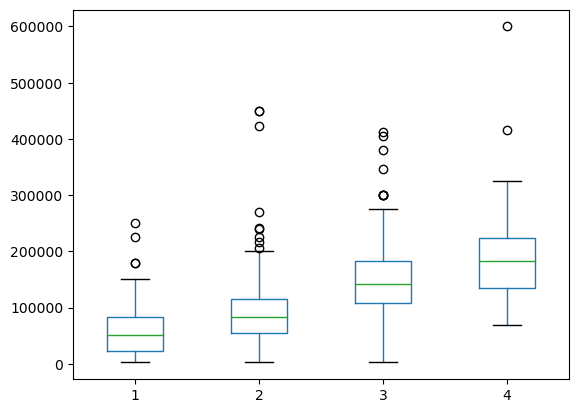

In [86]:
df.pivot(columns='experience_level',values='salary_in_usd').plot(kind='box')

<AxesSubplot:>

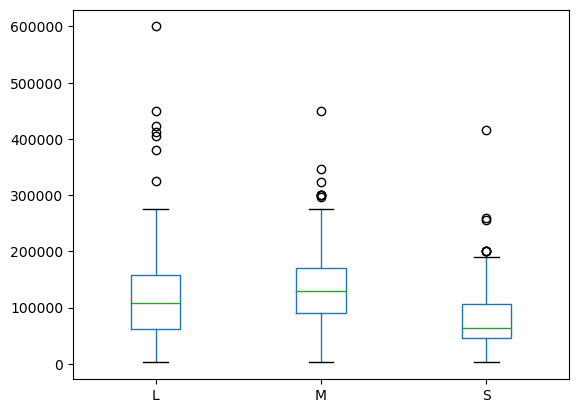

In [87]:
df.pivot(columns=['company_size'],values='salary_in_usd').plot(kind='box')

<AxesSubplot:>

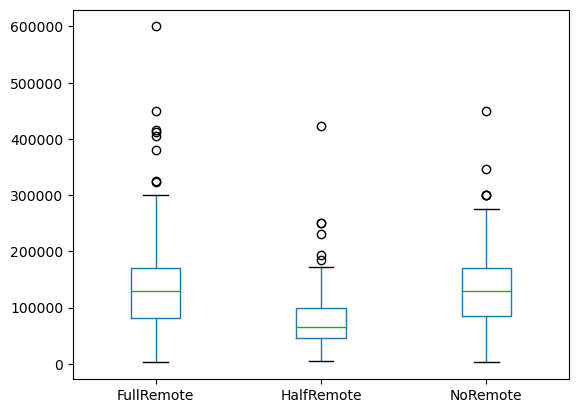

In [88]:
df.pivot(columns='remote_ratio',values='salary_in_usd').plot(kind='box')

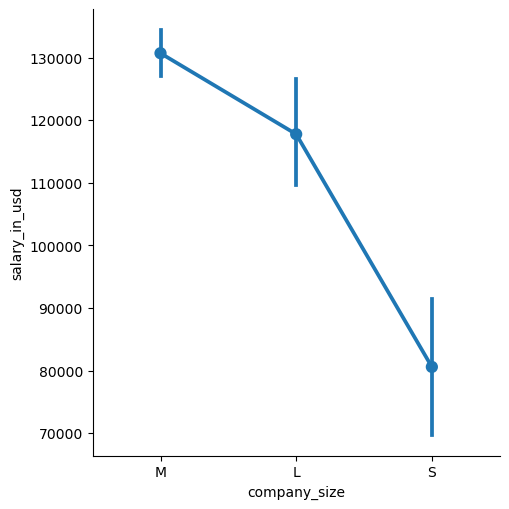

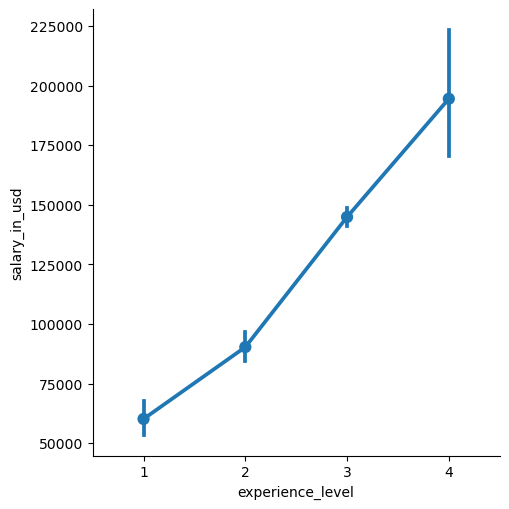

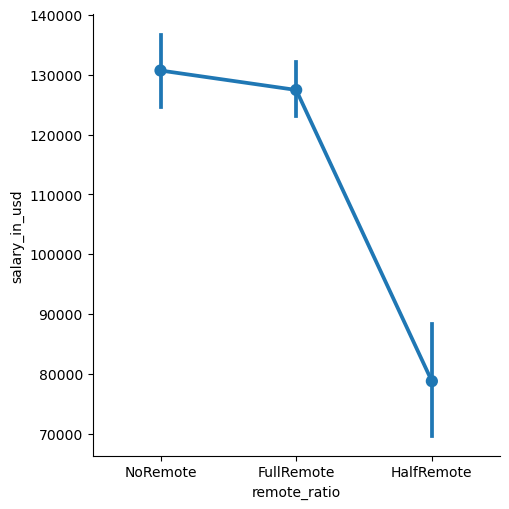

In [89]:
for i,col in enumerate(['company_size','experience_level','remote_ratio']):
    sns.catplot(x=col,y='salary_in_usd',data=df,kind='point')

Finally, we write our prepared data into a CSV file. In the next notebook, we will read this data for analysis, and might also alter as we experiment with a variety of models.

In [90]:
df.to_csv('./ai-ml-salaries-clean.csv',index=False)
df.head()

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size,employee_continent,company_continent,is_colocated
0,2022,2,FT,130000,NoRemote,M,NA,NA,1
1,2022,2,FT,90000,NoRemote,M,NA,NA,1
2,2022,2,FT,120000,FullRemote,M,NA,NA,1
3,2022,2,FT,100000,FullRemote,M,NA,NA,1
4,2022,2,FT,85000,FullRemote,M,NA,NA,1


In [91]:
df['salary_in_usd'].describe()

count      1332.000000
mean     123374.658408
std       65945.872172
min        2324.000000
25%       75593.000000
50%      120000.000000
75%      164997.000000
max      600000.000000
Name: salary_in_usd, dtype: float64